<pre>
<h1>Coding Project 1 For DLFA-spr2020</h1>
                                Submission BY: Raghwendra Dey
                                Roll No      : 18IE10018
</pre>

<h3>Questions:</h3><br>
1. how you have split the dataset into train, text, validation?<br>
Ans: First, I divided the whole dataset into train and test sets in a 9:1 split then that training dataset is further divided into train and valid sets in 9:1 split using random sampling from it.<br><br>
2. have you taken any methods to compensate for class imbalance?<br>
Ans: No.<br><br>
3. any conditions of hot restart during training?<br>
Ans: No.<br><br>
4. present the training/validation loss curves and indicate how you have chosen the stopping criteria?<br>
Ans: Training And Validation loss curves are after training and evaluation block.<br>
For stopping criteria i am observing the validation loss and stop when validation loss doesn't decrease further for consecutive *PATIENCE* (which is currently set to 5) number of epochs.<br><br>
5. calculate the model space and inference compute complexity and indicate it on your .ipynb. <br>
Ans: Model Space Complexity:<br>
Convolutional Layer 1: (3x5x5 + 1)x32 = 2432 params (=>2432x4 bytes)<br>
BatchNorm Layer 1: 2x32 = 64 params (=>64x4 bytes)<br>
Convolutional Layer 2: (32x3x3 + 1)x32 = 9248 params (=>9248x4 bytes)<br>
BatchNorm Layer 2: 2x32 = 64 params (=>64x4 bytes)<br>
Convolutional Layer 3: (32x5x5 + 1)x64 = 51264 params (=>51264x4 bytes)<br>
BatchNorm Layer 3: 2x64 = 128 params (=>128x4 bytes)<br>
Rest of the components dont have any trainable params<br>
<br>
Inference Compute Complexity (Assuming MAC processor) :<br>
&num; of Ops in Convolutional Layer 1: 32x(3x5x5+1)x(35)x(28) = 2383360<br>
&num; of Ops in BatchNorm Layer 1: 2x32x35x28 = 62720 (Since each pixel needs to be multiplied by gamma and then added with beta)<br>
&num; of Ops in MaxPool Layer 1: 32x(2x2-1)x(17)x(14) = 22848<br>
&num; of Ops in Convolutional Layer 2: 32x(32x3x3+1)x(19)x(16) = 2811392<br>
&num; of Ops in BatchNorm Layer 2: 2x32x19x16 = 19456 (Since each pixel needs to be multiplied by gamma and then added with beta)<br>
&num; of Ops in MaxPool Layer 2: 32x(2x2-1)x(9)x(8) = 6912<br>
&num; of Ops in Convolutional Layer 3: 64x(32x5x5+1)x(9)x(8) = 3691008<br>
&num; of Ops in BatchNorm Layer 3: 2x64x9x8 = 9216 (Since each pixel needs to be multiplied by gamma and then added with beta)<br>
&num; of Ops in MaxPool Layer 3: 64x(2x2-1)x(4)x(4) = 3072<br>
&num; of Ops in Fully Connected Layer 1: (64x4x4+1)x64 = 65600<br>
&num; of Ops in Fully Connected Layer 2: (64+1)x10 = 650<br>

In [2]:
import pandas as pd
import numpy as np
import cv2
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import glob

# Data Preprocessing 

In [3]:
# unzipping data files
# Modify this below variable to point to the location of BDRW_train_ (Remember don't put any 1 or 2 after BDRW_train_) 
base_file_name = "../input/bdrw/BDRW_train/BDRW_train_"
  
for i in range(2):
    with ZipFile(base_file_name+str(i+1)+'.zip', 'r') as zip: 
        print('Extracting all the files now...') 
        zip.extractall() 
        print('Done!') 

Extracting all the files now...
Done!
Extracting all the files now...
Done!


In [4]:
# Loading the Labels file
labels = pd.read_excel('BDRW_train_2/labels.xls', header=None, names=['digit_name', 'label'])
labels.head(10)

,digit_name,label
0,digit_0,1
1,digit_1,4
2,digit_2,2
3,digit_3,3
4,digit_4,1
5,digit_5,2
6,digit_6,3
7,digit_7,4
8,digit_8,5
9,digit_9,6


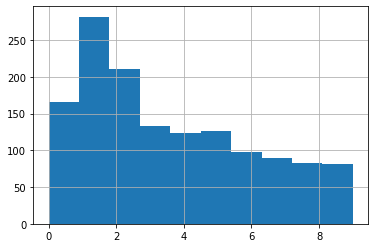

In [5]:
# Histogram of the data
labels['label'].hist()
labels = np.array(labels['label'])

In [6]:
# Sorting the images files according to the labels list and loading to a list
image_list = []
for i in range(2):
    for file in sorted(glob.glob('BDRW_train_'+str(i+1)+'/*.jpg'), key=lambda s:int(s.split('_')[-1].split('.')[0])):
        im = cv2.imread(file)
        image_list.append(im)
        
image_list = np.array(image_list)

array([35.45441493, 27.82483848])

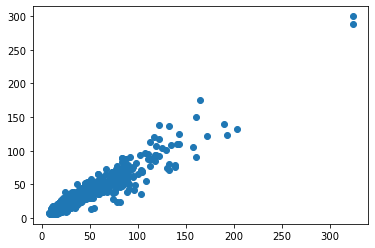

In [7]:
# Distribution of the shapes of the input images and finding the mean to resize all the images to that mean 
# height and width later.
shapes = np.array([x.shape for x in image_list]).T
plt.scatter(shapes[0], shapes[1])
np.mean(shapes[:2], axis=1)

# Model Building

In [8]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image

In [9]:
# Dataset class
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, image_list, labels, height, width):
        self.image_list = image_list
        self.labels = labels
        self.height = height
        self.width = width
        
    def transform(self):
        return(transforms.Compose([
            transforms.Resize(size=(self.height, self.width)),
            transforms.ToTensor()
        ]))
    
    def __getitem__(self, index):
        label = self.labels[index]
        im = self.image_list[index]
        im = Image.fromarray(im)
        im = self.transform()(im)
        
        return (im, label)
    
    def __len__(self):
        return len(self.image_list)

In [10]:
# Function to return the input pipelines for the model
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

def create_dataset(image_list, labels, BATCH_SIZE=64, TEST_SIZE=0.10, VALID_SIZE=0.05, HEIGHT=35, WIDTH=28):
    X_train, X_test, Y_train, Y_test = train_test_split(image_list, labels, test_size=TEST_SIZE)
    train_ds = custom_dataset(X_train, Y_train, HEIGHT, WIDTH)
    test_ds = custom_dataset(X_test, Y_test, HEIGHT, WIDTH)
    
    num_train = len(train_ds)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(VALID_SIZE*num_train))
    valid_idx, train_idx = indices[:split], indices[split:]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, sampler=valid_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, valid_loader, test_loader

In [11]:
# The Network
class conv(nn.Module):
    def __init__(self, num_classes=10):
        super(conv, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(4*4*64, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    

In [12]:
# Early Stopping class to stop when valid loss doesn't decrease further
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [13]:
# Training function
def training(model, LEARNING_RATE=0.001, PATIENCE=5, NUM_EPOCHS=50):
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)
    
    train_loss = []
    valid_loss = []
    train_acc = []
    
    total_step = len(train_loader)
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        tot = 0
        for i, (im, label) in enumerate(train_loader):
            im = im.to(device)
            label = label.to(device)
            
            out = model(im)
            loss = criterion(out, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(out.data, 1)
            tot += preds.size(0)
            running_acc += torch.sum(preds==label).item()
            
        epoch_loss = running_loss/(i+1)
        epoch_acc = running_acc/(tot)
        
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        model.eval()
        total = 0
        running_valid_loss = 0.0
        with torch.no_grad():
            for (im, label) in valid_loader:
                im = im.to(device)
                label = label.to(device)

                out = model(im)
                running_valid_loss += criterion(out, label).item()
                total += label.size(0)
        
        epoch_valid_loss = running_valid_loss/total
        valid_loss.append(epoch_valid_loss)
        print('Epoch {:.0f}/{:.0f} : Training Loss: {:.4f} | Validation Loss: {:.4f} | Training Accuracy: {:.4f} %'
                    .format(epoch+1, NUM_EPOCHS, epoch_loss, epoch_valid_loss, epoch_acc*100))
        
        early_stopping(epoch_valid_loss, model)
        if early_stopping.early_stop:
            print("Early Stopping!!!")
            break
            
    model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_loss, valid_loss, train_acc

In [14]:
# Evaluation function
def evaluate(model):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for (im, label) in test_loader:
            im = im.to(device)
            label = label.to(device)
            
            out = model(im)
            _, preds = torch.max(out.data, axis=1)
            total += label.size(0)
            correct += (preds==label).sum().item()
            
        print('Test Accuracy : {} %'.format(100*correct/total))
        

In [15]:
if torch.cuda.is_available():
    print("GPU is available :D")
    device = torch.device('cuda:0')
else:
    print("GPU is not available ;-;")
    device = torch.device('cpu')

GPU is not available ;-;


<h2>Training</h2>

In [16]:
# Hyperparameters
PATIENCE = 5
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
HEIGHT = 35
WIDTH = 28
BATCH_SIZE = 64
TEST_SIZE = 0.10
VALID_SIZE = 0.10

# Model Object Initialization
model = conv()

# Data loaders
train_loader, valid_loader, test_loader = create_dataset(
                                                     image_list,
                                                     labels,
                                                     BATCH_SIZE=BATCH_SIZE,
                                                     VALID_SIZE=VALID_SIZE,
                                                     TEST_SIZE=TEST_SIZE,
                                                     HEIGHT=HEIGHT,
                                                     WIDTH=WIDTH,
                                                )

# Starting training
model, train_loss, valid_loss, train_acc = training(
                                                model, 
                                                LEARNING_RATE=LEARNING_RATE, 
                                                PATIENCE=PATIENCE, 
                                                NUM_EPOCHS=NUM_EPOCHS
                                            )

Epoch 1/50 : Training Loss: 2.1802 | Validation Loss: 0.0346 | Training Accuracy: 22.5177 %
Validation loss decreased (inf --> 0.034587).  Saving model ...
Epoch 2/50 : Training Loss: 1.8069 | Validation Loss: 0.0239 | Training Accuracy: 38.2092 %
Validation loss decreased (0.034587 --> 0.023945).  Saving model ...
Epoch 3/50 : Training Loss: 1.2948 | Validation Loss: 0.0157 | Training Accuracy: 59.4858 %
Validation loss decreased (0.023945 --> 0.015737).  Saving model ...
Epoch 4/50 : Training Loss: 0.8352 | Validation Loss: 0.0089 | Training Accuracy: 77.6596 %
Validation loss decreased (0.015737 --> 0.008908).  Saving model ...
Epoch 5/50 : Training Loss: 0.5630 | Validation Loss: 0.0070 | Training Accuracy: 85.9043 %
Validation loss decreased (0.008908 --> 0.006974).  Saving model ...
Epoch 6/50 : Training Loss: 0.4317 | Validation Loss: 0.0058 | Training Accuracy: 88.8298 %
Validation loss decreased (0.006974 --> 0.005843).  Saving model ...
Epoch 7/50 : Training Loss: 0.3439 | Va

In [17]:
# Inference
evaluate(model)

Test Accuracy : 95.71428571428571 %


<h2>Training and Validation loss curves</h2>

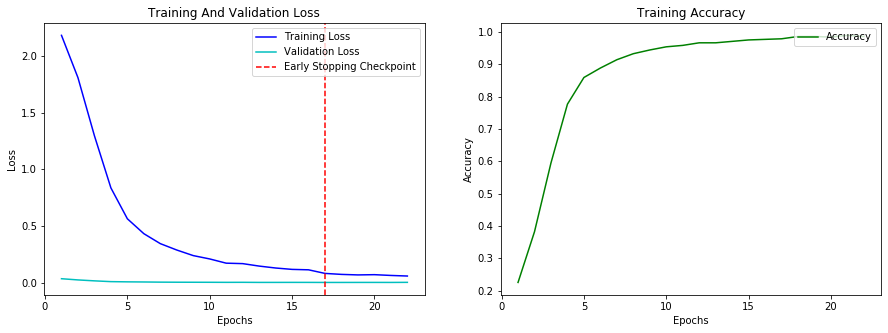

In [18]:
fig = plt.figure(figsize=[15, 5])

plt.subplot(121)
plt.plot(range(1, len(train_loss)+1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(valid_loss)+1), valid_loss, 'c', label='Validation Loss')
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.gca().set_title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(122)
plt.plot(range(1, len(train_acc)+1), train_acc, 'g', label='Accuracy')
plt.gca().set_title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')